In [8]:
from __future__ import print_function, division
import scipy


import keras
from keras.datasets import mnist
#from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
import datetime
import matplotlib.pyplot as plt
import sys
from data_loader import DataLoader
import numpy as np
import os
from glob import glob

In [25]:
def gen_data(f_mean_shift=(2,3), fvar=2, g_mean_shift=(-1,-1), gvar=0.5, num_pts=10000, mean=(0,0), var=1.0, batch_size=1):
        #data_type = "train%s" % domain if not is_testing else "test%s" % domain
        cov=var*np.eye(2)
        orig = np.random.multivariate_normal(mean, cov, num_pts)
        fmean=np.asarray(mean)+np.asarray(f_mean_shift)
        fpts= np.random.multivariate_normal(fmean, fvar*cov, num_pts)
        gmean=np.asarray(mean)+np.asarray(g_mean_shift)
        gpts=np.random.multivariate_normal(gmean, gvar*cov, num_pts)

        return orig, fpts, gpts

In [56]:
class CycleGAN():
    def __init__(self, data_A, data_B, lr_G=0.001, lr_D=0.0005):
        
        #
        self.data_shape=(2,)
        self.data_dim=2

        # Loss weights
        ##################################
        # First change: set cycle-consistency weight to unit.
        # Could probably do the same to identity-loss weight
        # without much change, but the lambda_cycle weight
        # did seem to have an effect
        ##################################
        self.lambda_cycle = 1.0                    # Cycle-consistency loss
        self.lambda_id = 0.01 * self.lambda_cycle    # Identity loss

        ##################################
        # Second change: optimizers
        # Start with SGD on easy data, then consider using Adam/RMSprop when you
        # get a feel for how training will go. The former is simpler and more
        # predictable, the latter can be erratic if you don't understand how to
        # set the hyperparameters.
        #
        # And then: different learning rates for generator and discriminator.
        # I'm suspicious of anyone who doesn't do this unless the discriminator
        # is non-sigmoid.
        # I'm suspicious of non-sigmoid discriminators except Wasserstein GAN.
        ##################################
        optimizer_G = SGD(lr=lr_G)
        optimizer_D = SGD(lr=lr_D)

        ##################################
        # Third change: discriminator loss
        # The original CycleGAN authors used MSE instead of BCE.
        # They cited some paper I've never heard of which claimed
        # that it encourages stability.
        # This sounds like a poor-man's Wasserstein GAN without
        # any of the analysis to back it up, FWIW.
        # Switched back to BCE because we know it works on
        # other types of GANs.
        #
        # ALSO: The discriminator's output layer had a sigmoid
        # activation, which doesn't make sense with MSE.
        # If you look in the original cyclegan.py, the
        # discriminator's final layer was the default activation,
        # which is linear. This makes more sense with MSE.
        # I also tried leaving MSE loss, and making the discriminator's
        # last activation linear, but that didn't work as well.
        ##################################
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='binary_crossentropy',
            optimizer=optimizer_D,
            metrics=['accuracy'])
        self.d_B.compile(loss='binary_crossentropy',
            optimizer=optimizer_D,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input instances from both domains
        datum_A = Input(shape=self.data_shape)
        datum_B = Input(shape=self.data_shape)


        #Is this going to work the way I have it here
        #or should I be taking something from a batch?
        # Translate images to the other domain
        fake_B = self.g_AB(datum_A)
        fake_A = self.g_BA(datum_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        datum_A_id = self.g_BA(datum_A)
        datum_B_id = self.g_AB(datum_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        ##################################
        # Third change (part two): consistent switch to BCE
        # for all discriminator losses
        ##################################
        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[datum_A, datum_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        datum_A_id, datum_B_id ])
        self.combined.compile(loss=['binary_crossentropy', 'binary_crossentropy',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer_G)

    

    def build_generator(self):
        """
        Simple MLP generator for the MoG unrolled GAN toy experiment
        """

        gen_input = Input(shape=(self.data_dim,), name="generator_input")

        ##################################
        # Fourth change: made this tanh instead of relu.
        # I suspect the important thing is to have similar activations
        # in generator and discriminator, but who knows.
        # Could also try relu in both, but I would use LeakyReLU.
        ##################################
        x = Dense(2*self.data_dim)(gen_input)
        x = Activation("tanh")(x)
     #     for i in range(2):
        x = Dense(2*self.data_dim)(x)
        x = Activation("tanh")(x)
        x = Dense(2)(gen_input)
        

        generator_model = Model(inputs=[gen_input], outputs=[x])
        #visualize_model(generator_model)

        return generator_model

#        
    def build_discriminator(self):

        """
        Simple MLP discriminator for the MoG unrolled GAN toy experiment
        """

        disc_input = Input(shape=(2,), name="discriminator_input")

        x = Dense(2*self.data_dim)(disc_input)
        x = Activation("tanh")(x)
    #     for i in range(2):
        x = Dense(2*self.data_dim)(x)
        x = Activation("tanh")(x)
        x = Dense(1, activation="sigmoid")(x)

        discriminator_model = Model(inputs=[disc_input], outputs=[x])
        #visualize_model(discriminator_model)

        #is there a difference between what this returns and the original cycelgan does?
        return discriminator_model

    
    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,)) #+ self.disc_patch)
        fake = np.zeros((batch_size,)) #+ self.disc_patch)
#         self.g_AB.summary()
#         self.g_BA.summary()
#         self.d_A.summary()
#         self.d_B.summary()
        self.n_batches = int(min(len(data_A), len(data_B)) / batch_size)
        #total_samples = self.n_batches * batch_size
        for epoch in range(epochs):
            for i in range(self.n_batches-1):
                #randomly shuffle data?
                
                #take the corresponding "Batch size" number of elements
                batch_A = data_A[i*batch_size:(i+1)*batch_size]
                batch_B = data_B[i*batch_size:(i+1)*batch_size]
                #put them through this thing
                
                
                # ----------------------
                #  Train Discriminators
                # ----------------------
               # print(imgs_A.shape)

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(batch_A)
                fake_A = self.g_BA.predict(batch_B)
                #print(fake_A.shape)
                #print(fake_B.shape)
                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(batch_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(batch_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([batch_A, batch_B],
                                                        [valid, valid,
                                                        batch_A, batch_B,
                                                        batch_A, batch_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
            if epoch % sample_interval == 0:
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            i, self.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_data(epoch, i)

    def sample_data(self, epoch, batch_i):
       # r, c = 2, 3

        orig2, pic_data_A, pic_data_B= gen_data((10,10), 3, (-7,6), .25, 1000)
        
    
        # Translate images to the other domain
        fake_B = self.g_AB.predict(pic_data_A)
        fake_A = self.g_BA.predict(pic_data_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)
        
        fig = plt.figure(figsize=(12,7))
        ax1 = fig.add_subplot(131)

        ax1.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='OA')
        ax1.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='FA')
        ax1.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='RA')
        plt.legend(loc='upper left');
        
        ax2=fig.add_subplot(132)
        ax2.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='b', marker="s", label='OB')
        ax2.scatter(fake_B[:,0], fake_B[:,1], s=25, c='r', marker="o", label='FB')
        ax2.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='g', marker="o", label='RB')
        plt.legend(loc='upper left');
        
        ax3=fig.add_subplot(133)
        ax3.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='OA')
        ax3.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='FA')
        ax3.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='RA')
        ax3.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='c', marker="s", label='OB')
        ax3.scatter(fake_B[:,0], fake_B[:,1], s=25, c='m', marker="o", label='FB')
        ax3.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='y', marker="o", label='RB')
        plt.legend(loc='upper left');
        
        plt.show()
        plt.clf()
        fig.savefig("images/%d_%d.png" % (epoch, batch_i))
        plt.close()

In [57]:
orig, data_A, data_B=gen_data((10,10), 3, (-7,6), .25, 1000)

[Epoch 0/1000] [Batch 248/250] [D loss: 0.599780, acc:  75%] [G loss: 7.547698, adv: 0.803956, recon: 2.877173, id: 9.233442] time: 0:00:02.095623 


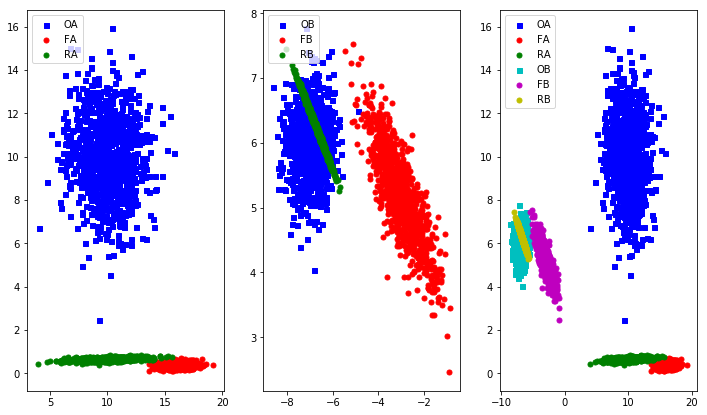

[Epoch 50/1000] [Batch 248/250] [D loss: 0.696538, acc:  56%] [G loss: 1.830183, adv: 0.654231, recon: 0.177580, id: 9.886597] time: 0:00:25.590762 


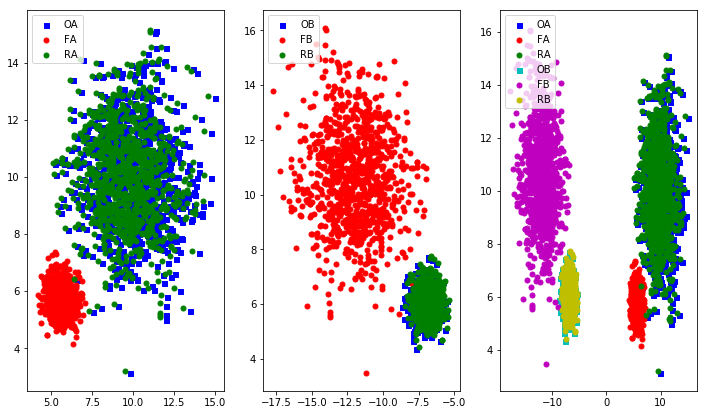

[Epoch 100/1000] [Batch 248/250] [D loss: 0.649951, acc:  62%] [G loss: 1.789078, adv: 0.669126, recon: 0.133194, id: 12.248772] time: 0:00:49.047684 


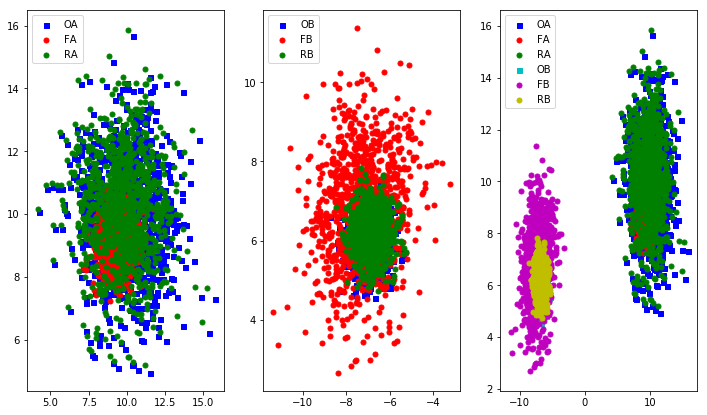

[Epoch 150/1000] [Batch 248/250] [D loss: 0.699836, acc:  56%] [G loss: 1.850479, adv: 0.636575, recon: 0.171775, id: 17.209137] time: 0:01:13.837904 


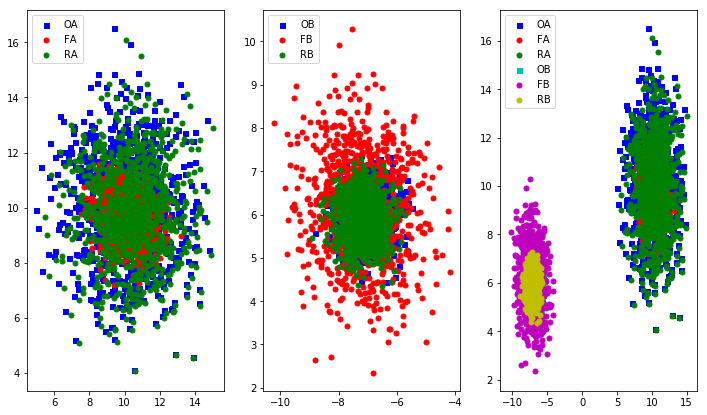

[Epoch 200/1000] [Batch 248/250] [D loss: 0.668613, acc:  62%] [G loss: 2.123912, adv: 0.635716, recon: 0.303877, id: 18.380203] time: 0:01:38.124702 


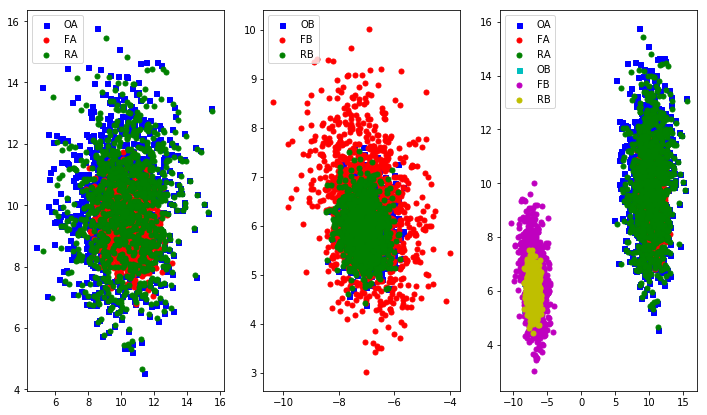

[Epoch 250/1000] [Batch 248/250] [D loss: 0.576207, acc:  62%] [G loss: 2.176196, adv: 0.656269, recon: 0.314489, id: 17.515530] time: 0:02:02.858623 


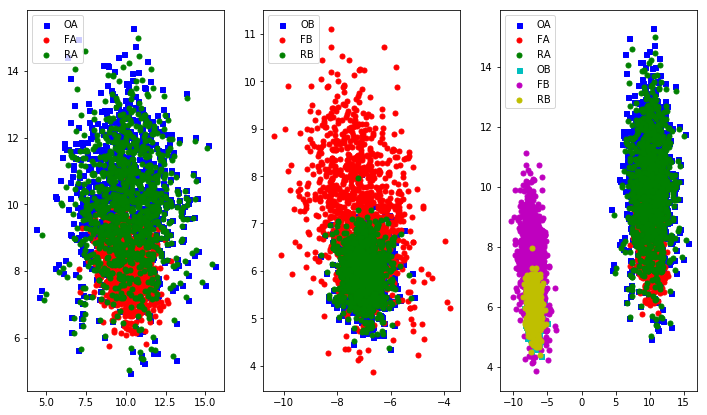

[Epoch 300/1000] [Batch 248/250] [D loss: 0.722918, acc:  56%] [G loss: 1.837998, adv: 0.630702, recon: 0.164967, id: 18.718052] time: 0:02:27.198898 


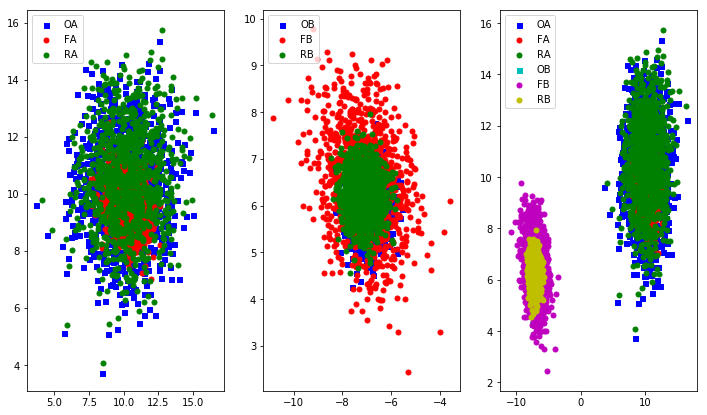

[Epoch 350/1000] [Batch 248/250] [D loss: 0.699672, acc:  62%] [G loss: 2.045507, adv: 0.642137, recon: 0.257790, id: 18.706978] time: 0:02:51.572080 


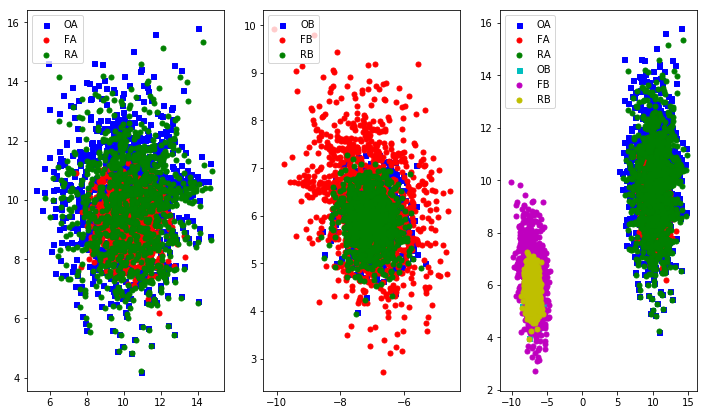

[Epoch 400/1000] [Batch 248/250] [D loss: 0.710763, acc:  62%] [G loss: 2.312094, adv: 0.646230, recon: 0.386624, id: 18.894863] time: 0:03:16.369736 


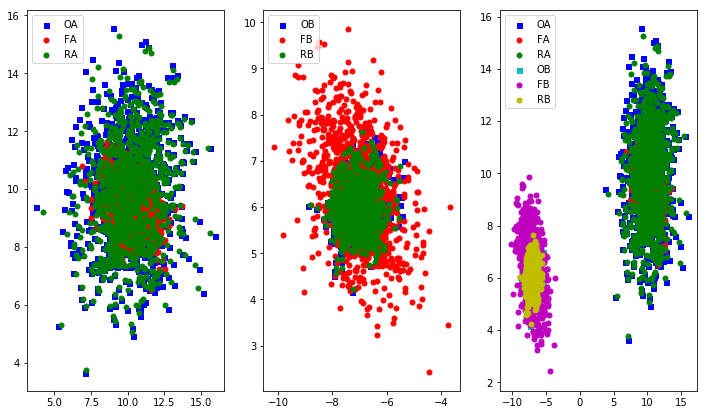

[Epoch 450/1000] [Batch 248/250] [D loss: 0.640352, acc:  62%] [G loss: 1.967976, adv: 0.656892, recon: 0.207230, id: 18.418507] time: 0:03:40.817508 


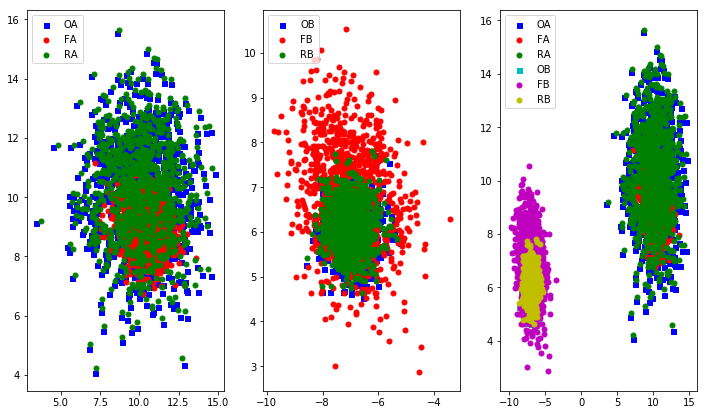

[Epoch 500/1000] [Batch 248/250] [D loss: 0.674780, acc:  56%] [G loss: 1.867496, adv: 0.659759, recon: 0.153234, id: 18.653370] time: 0:04:05.524209 


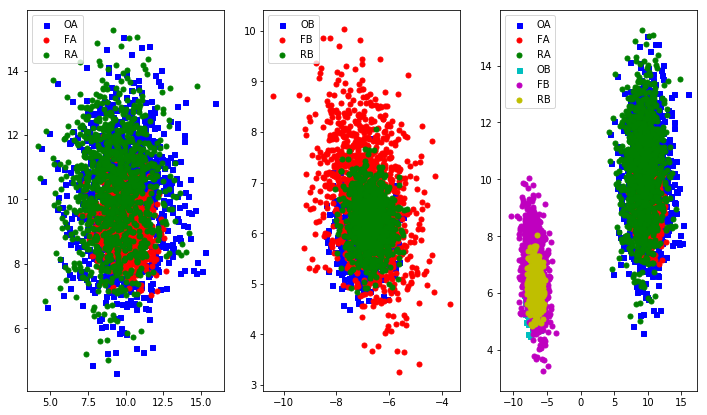

[Epoch 550/1000] [Batch 248/250] [D loss: 0.722925, acc:  56%] [G loss: 1.829375, adv: 0.658664, recon: 0.136063, id: 18.666258] time: 0:04:30.064252 


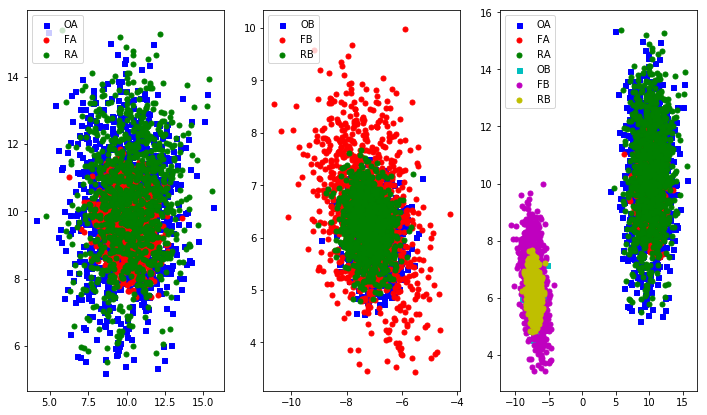

[Epoch 600/1000] [Batch 248/250] [D loss: 0.666106, acc:  56%] [G loss: 2.084474, adv: 0.657054, recon: 0.266008, id: 18.605362] time: 0:04:54.956501 


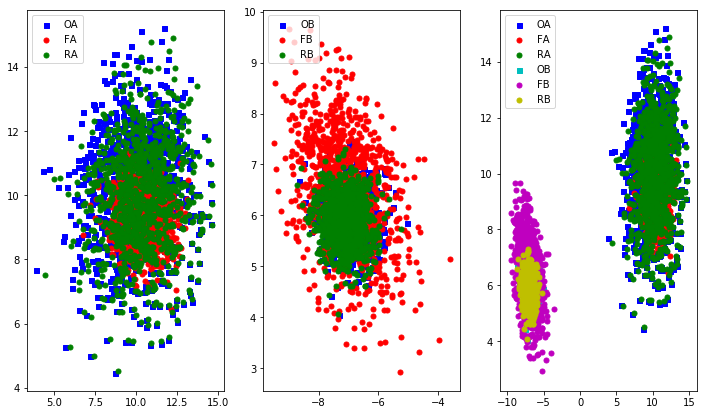

[Epoch 650/1000] [Batch 248/250] [D loss: 0.735298, acc:  62%] [G loss: 2.201141, adv: 0.690696, recon: 0.284518, id: 19.918407] time: 0:05:19.635256 


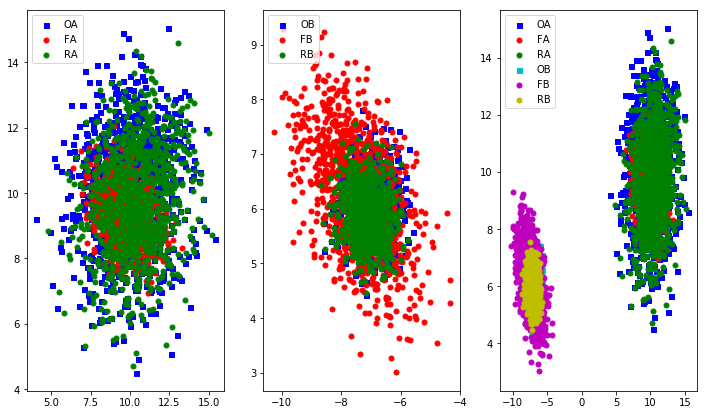

[Epoch 700/1000] [Batch 248/250] [D loss: 0.727920, acc:  62%] [G loss: 2.211098, adv: 0.720276, recon: 0.255036, id: 21.137943] time: 0:05:44.445125 


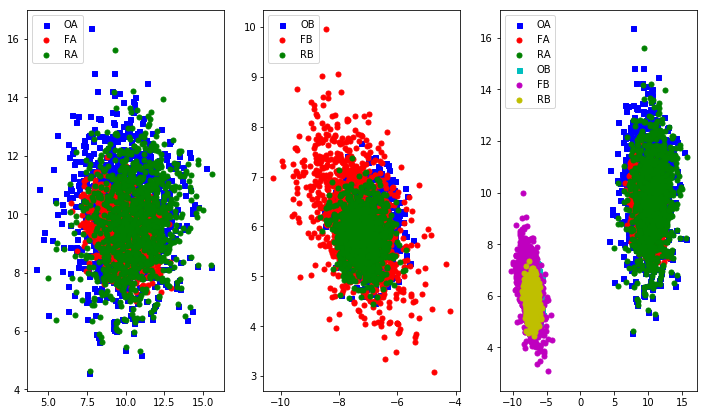

[Epoch 750/1000] [Batch 248/250] [D loss: 0.709911, acc:  62%] [G loss: 2.242307, adv: 0.735770, recon: 0.254208, id: 21.588799] time: 0:06:09.310974 


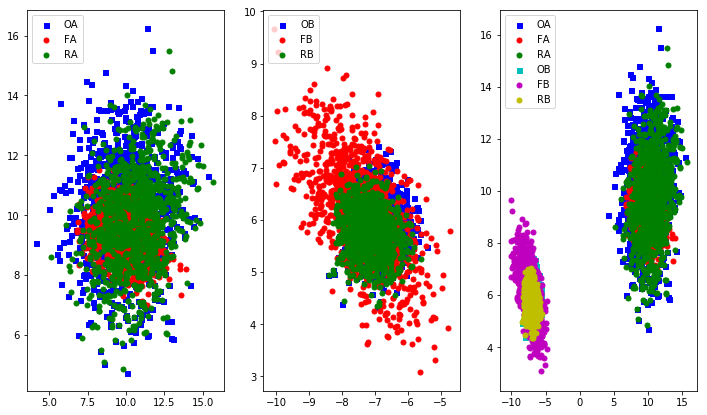

[Epoch 800/1000] [Batch 248/250] [D loss: 0.720757, acc:  62%] [G loss: 2.371390, adv: 0.736277, recon: 0.316817, id: 21.992659] time: 0:06:33.019343 


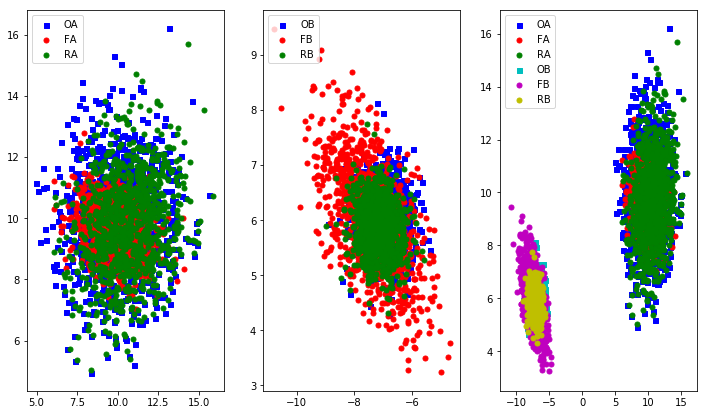

[Epoch 850/1000] [Batch 248/250] [D loss: 0.696652, acc:  62%] [G loss: 2.352255, adv: 0.740221, recon: 0.303701, id: 21.993177] time: 0:06:56.840419 


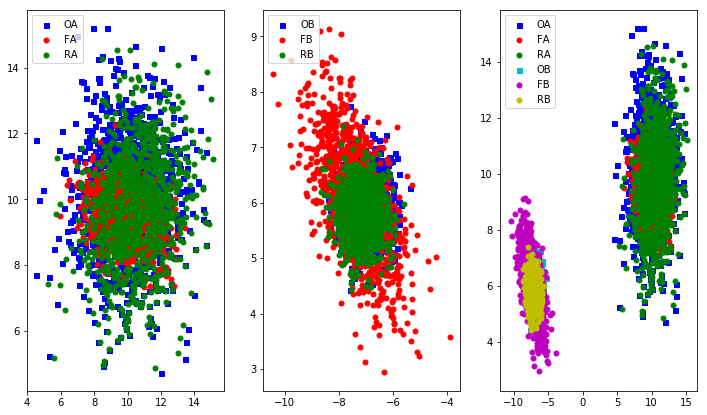

[Epoch 900/1000] [Batch 248/250] [D loss: 0.705868, acc:  62%] [G loss: 2.299303, adv: 0.733007, recon: 0.285219, id: 21.850832] time: 0:07:20.621508 


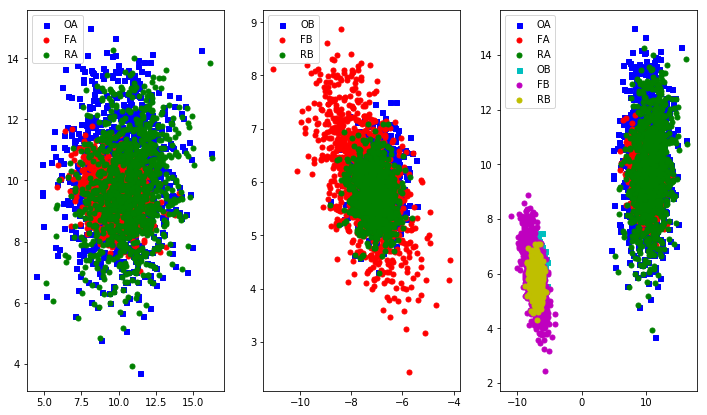

[Epoch 950/1000] [Batch 248/250] [D loss: 0.697299, acc:  62%] [G loss: 2.325470, adv: 0.738391, recon: 0.293914, id: 21.623472] time: 0:07:44.345985 


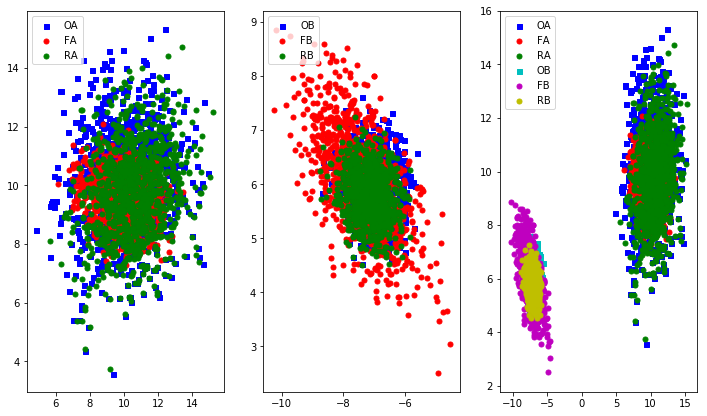

In [58]:
gan = CycleGAN(data_A, data_B)
gan.train(epochs=1000, batch_size=4, sample_interval=50)